## Charger les packages

In [2]:
import numpy as np
import matplotlib.pyplot as pl
import sys
from ipywidgets import interact, widgets
import os
import scipy.io.wavfile as wav

%matplotlib inline

In [3]:
PATH = './vowels/vowels'

## Lire les fichiers son

Lecture des fichiers .wav donnés et extractions des coefficients de Mel.
Création des 3 tableaux pour les comparaisons demandées :

- Homme vs Femme (voix naturelles uniquement)
- Homme vs Femme (vois naturelles et synthétiques)
- Homme vs Femme vs Enfant (voix naturelles et synthétiques)

In [93]:
from python_speech_features import mfcc

SAMPLE_RATE = 24000

part_1 = []
part_2 = []
part_3 = []

for f in os.listdir(PATH):
    if(f.endswith(".wav")): #Skip the readme
        # Check for natural/synthetical voice
        type_ns = 1 if (f[0] == 'n') else -1
        
        # Check for adult/kid voice
        type_ak = 1 if (f[1] == 'a') else -1
        
        # Check for male/female voice
        if type_ak == 1:
            type_mf = 1 if f[2] == 'f' else -1
            
        # Group male/female and kids informations
        if type_ak == -1:
            type_mfk = -1 # kid
        else:
            if type_mf == -1:
                type_mfk = 0 # male
            else:
                type_mfk = 1 # female
            
        
        coefs = mfcc(wav.read(os.path.join(PATH, f))[1], SAMPLE_RATE, nfft=1024)
        coefs_avg = np.average(coefs, axis=0) # Aggregate the values
        
        if type_ns == 1 and type_ak == 1: # Only natural adult voices
            part_1.append(np.append(coefs_avg, type_mf)) # Add gender
        
        if type_ak == 1: # On adult voices. Both natural & synthetical
            part_2.append(np.append(coefs_avg, type_mf)) # Add gender
            
        # All voices
        part_3.append(np.append(coefs_avg, type_mfk)) # Add gender or age
        
part1_ar = np.array(part_1)
part2_ar = np.array(part_2)
part3_ar = np.array(part_3)

print(len(part1_ar))
print(len(part2_ar))
print(len(part3_ar))

72
144
360


## Importer les algorithmes de MLP (Multi-Layer Perceptron) et Cross-Validation

In [117]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

## Explorer les époques

In [111]:
N_INITS = 10
EPOCHS = 100
N_NEURONS = [2, 4, 8]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

K = 5
N_TESTS = 10

In [97]:
#print(part3_ar[:,0:13])
#print(part3_ar[:,13:14])

In [112]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        
        MSE[i_h, i, :] = nn.fit((part1_ar[:,0:13], part1_ar[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


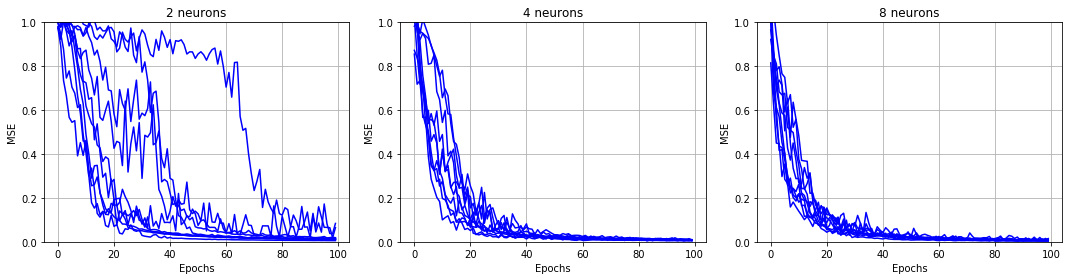

In [113]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

In [114]:
MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                      # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                         # looping the tests
        nn.init_weights()                                                # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,          # notice that we do not use cv.k_fold_cross_validation
                                                            part1_ar,# but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,         # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


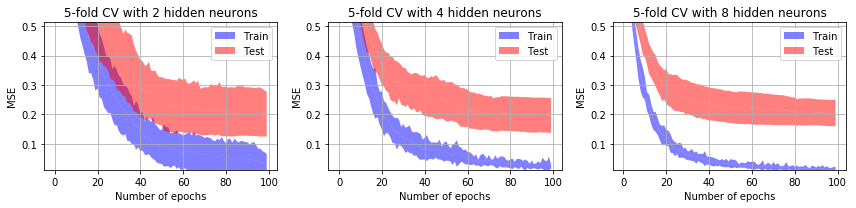

In [115]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

In [116]:
nn = mlp.MLP([13,2,1], 'tanh')

MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          part1_ar,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=75,
                                                          threshold=0.0)

print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.041834546592224714
MSE test:  0.2582156060581319
Confusion matrix:
[[35.  1.]
 [ 4. 32.]]
